In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb

from cam_calibrator import CameraCalibrator

In [2]:
cc = CameraCalibrator()

cal_img_path = './webcam_12'  # Location of calibration images
name = 'webcam'               # Name of the camera
n_corners = [7, 9]            # Corner grid dimensions
square_length = 0.0205        # Chessboard square length in meters

display_flag = False
cc.loadImages(cal_img_path, name, n_corners, square_length, display_flag)

u_meas, v_meas = cc.getMeasuredPixImageCoord()

*** Added sample 1, p_x = 0.516, p_y = 0.498, p_size = 0.370, skew = 0.517
*** Added sample 2, p_x = 0.565, p_y = 0.466, p_size = 0.554, skew = 0.210
*** Added sample 3, p_x = 0.352, p_y = 0.516, p_size = 0.472, skew = 0.020
*** Added sample 4, p_x = 0.747, p_y = 0.302, p_size = 0.292, skew = 0.073
*** Added sample 5, p_x = 0.564, p_y = 0.556, p_size = 0.386, skew = 0.874
*** Added sample 6, p_x = 0.473, p_y = 0.431, p_size = 0.327, skew = 0.433
*** Added sample 7, p_x = 0.461, p_y = 0.633, p_size = 0.447, skew = 0.464
*** Added sample 8, p_x = 0.500, p_y = 0.350, p_size = 0.466, skew = 0.309
*** Added sample 9, p_x = 0.566, p_y = 0.512, p_size = 0.397, skew = 0.072
*** Added sample 10, p_x = 0.505, p_y = 0.474, p_size = 0.467, skew = 0.012
*** Added sample 11, p_x = 0.490, p_y = 0.553, p_size = 0.474, skew = 0.169
*** Added sample 12, p_x = 0.578, p_y = 0.517, p_size = 0.420, skew = 0.270


## Problem 1.1 - gen world coordinates

In [3]:
#X = [(cc.n_corners_x - 1) * cc.d_square -cc.d_square*float(i%cc.n_corners_x) for i in range(len(u_meas[0]))] # from bottom right corner 
#Y = [cc.d_square*float(i/cc.n_corners_x) for i in range(len(v_meas[0]))]

# origin = top left, x increases to the right, y increases down
X = [cc.d_square*float(i%cc.n_corners_x) for i in range(len(u_meas[0]))] # from bottom right corner 
Y = [cc.d_square*float(i/cc.n_corners_x) for i in range(len(v_meas[0]))]

## 1.1 - Estimate H

In [4]:
M = np.vstack((X, Y, [1.0 for _ in range(len(X))]))

In [5]:
u = np.dot(np.array([u_meas[1]]).T, np.ones([1,3]))
v = np.dot(np.array([v_meas[1]]).T, np.ones([1,3]))
uM = -u*M.T
vM = -v*M.T

In [6]:
L1 = np.hstack((M.T, np.zeros(M.T.shape), uM))
L2 = np.hstack((np.zeros(M.T.shape), M.T, vM))
L = np.vstack((L1,L2))
print L

[[  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,  -0.00000000e+00
   -0.00000000e+00  -6.73394653e+02]
 [  2.05000000e-02   0.00000000e+00   1.00000000e+00 ...,  -1.25192964e+01
   -0.00000000e+00  -6.10697388e+02]
 [  4.10000000e-02   0.00000000e+00   1.00000000e+00 ...,  -2.23543641e+01
   -0.00000000e+00  -5.45228394e+02]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -5.63540821e+01
   -5.63540821e+01  -4.58163269e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -6.55979805e+01
   -5.62268405e+01  -4.57128784e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -7.47379050e+01
   -5.60534288e+01  -4.55718933e+02]]


In [7]:
# #SVD:  L == U * S * V
U,S,V  = np.linalg.svd(L,full_matrices=False)
#L_recon = np.dot(U, np.diag(S).dot(V))

In [8]:
h = V[-1] # eignevector associated with smallest singular value in S, which is the last vector in V

In [9]:
H = h.reshape(3,3)

In [10]:
H

array([[ -7.01951942e-01,   1.16080758e-01,   1.55676965e-01],
       [  1.98357279e-02,   6.84149401e-01,   3.31580153e-02],
       [  5.07618366e-05,   2.04924974e-04,   2.30544492e-04]])

In [11]:
# Test (x should be the vector with the smallest norm)
x = V[8]
# should be smallest norm
x.T.dot(L.T.dot(L).dot(x))

4.1713064438469355e-06

In [12]:
def estimateHomography(u_meas, v_meas, X, Y):
    # form matrix L
    M = np.vstack((X, Y, [1.0 for _ in range(len(X))]))
    
    u = np.dot(np.array([u_meas]).T, np.ones([1,3]))
    v = np.dot(np.array([v_meas]).T, np.ones([1,3]))
    uM = u*M.T
    vM = v*M.T
    
    L1 = np.hstack((M.T, np.zeros(M.T.shape), -uM))
    L2 = np.hstack((np.zeros(M.T.shape), M.T, -vM))
    L = np.vstack((L1, L2))
    
    # SVD
    U,S,V  = np.linalg.svd(L,full_matrices=False)
    h = V[-1] # eigenvector associated with smallest singular value in S, which is the last vector in V
    H = h.reshape(3,3)
    
    return H

In [13]:
estimateHomography(u_meas[0], v_meas[0], X, Y)

array([[ -3.94841203e-01,  -6.61312666e-01,   2.41062973e-01],
       [ -3.27535989e-01,   4.76329715e-01,   1.20351463e-01],
       [  3.90625157e-04,  -1.54452864e-04,   3.91028866e-04]])

In [14]:
H_dict = {}
for i in range(len(u_meas)):
    H_dict[i] = estimateHomography(u_meas[i], v_meas[i], X, Y)

In [15]:
H_dict

{0: array([[ -3.94841203e-01,  -6.61312666e-01,   2.41062973e-01],
        [ -3.27535989e-01,   4.76329715e-01,   1.20351463e-01],
        [  3.90625157e-04,  -1.54452864e-04,   3.91028866e-04]]),
 1: array([[ -7.01951942e-01,   1.16080758e-01,   1.55676965e-01],
        [  1.98357279e-02,   6.84149401e-01,   3.31580153e-02],
        [  5.07618366e-05,   2.04924974e-04,   2.30544492e-04]]),
 2: array([[ -7.15375433e-01,   1.60116446e-01,  -5.00792513e-02],
        [  1.44772679e-01,   6.47786310e-01,  -1.39665526e-01],
        [ -8.19765419e-05,  -3.84307068e-06,  -2.91024097e-04]]),
 3: array([[ -6.84755400e-01,  -1.05801230e-01,  -2.20380526e-01],
        [  1.44754870e-01,   6.24391474e-01,  -2.46027513e-01],
        [  1.73362869e-04,  -2.04107182e-04,  -5.19792064e-04]]),
 4: array([[  7.10778099e-01,   3.84169120e-01,  -2.48065891e-01],
        [ -5.99871308e-02,  -5.26452391e-01,  -7.01495644e-02],
        [ -2.64886436e-04,   3.72721065e-04,  -3.86942480e-04]]),
 5: array([[  6

## 1.3 - estimate camera intrinsics

In [21]:
def getCameraIntrinsics(H):
    V = np.zeros([1,6])

    for _,Hmat in H.iteritems():
        h1 = Hmat.T[0]
        h2 = Hmat.T[1]
        h3 = Hmat.T[2]

        #v_ij = [hi1*hj1,    hi1*hj2+hi2*hj1,         hi2*hj2,     hi3*hj1 + hi1*hj3,       hi3*hj2 + hi2*hj3,       hi3*hj3]
        v_11 = [h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1], h1[2]*h1[0]+h1[0]*h1[2], h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]]
        v_22 = [h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1], h2[2]*h2[0]+h2[0]*h2[2], h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]]
        v_12 = [h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]]

        if V.shape[0] < 2:
            V = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
        else:
            V2 = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
            V = np.vstack((V,V2))

    U,S,V_ = np.linalg.svd(V,full_matrices=False)
    b = V_[-1]

    B = np.array([
        [b[0], b[1], b[3]],
        [b[1], b[2], b[4]],
        [b[3], b[4], b[5]]
    ])

    v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2])/(B[0,0]*B[1,1] - B[0,1]**2)
    lam = B[2,2] - (B[0,2]**2 + v0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
    alpha = np.sqrt(lam/B[0,0])
    beta = np.sqrt(lam*B[0,0] / (B[0,0]*B[1,1] - B[0,1]**2))
    gamma = -B[0,1]* alpha**2 * beta / lam
    u0 = (gamma*v0/alpha) - (B[0,2]*alpha**2 / lam)

    A = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])

    return A

In [17]:
A = getCameraIntrinsics(H_dict)
A

array([[  1.31777815e+03,   4.00901096e+01,   4.12505964e+02],
       [  0.00000000e+00,   1.22400000e+03,   2.93599285e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [18]:
H = H_dict[0]
H

array([[ -3.94841203e-01,  -6.61312666e-01,   2.41062973e-01],
       [ -3.27535989e-01,   4.76329715e-01,   1.20351463e-01],
       [  3.90625157e-04,  -1.54452864e-04,   3.91028866e-04]])

In [19]:
#v_ij = [hi1*hj1, hi1*hj2+hi2*hj1, hi2*hj2, hi3*hj1 + hi1*hj3, hi3*hj2 + hi2*hj3, hi3*hj3]
h1 = H.T[0]
h2 = H.T[1]
h3 = H.T[2]

v_11 = [h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1], h1[2]*h1[0]+h1[0]*h1[2], h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]]
v_22 = [h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1], h2[2]*h2[0]+h2[0]*h2[2], h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]]
v_12 = [h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]]
v_12

[0.26111348846398008,
 0.028529100691294162,
 -0.15601512431849943,
 -0.00019734100956085202,
 0.00023665524106161127,
 -6.0333174060492602e-08]

In [20]:
V = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
V

array([[  2.61113488e-01,   2.85291007e-02,  -1.56015124e-01,
         -1.97341010e-04,   2.36655241e-04,  -6.03331741e-08],
       [ -2.81434867e-01,   8.88655155e-01,  -1.19610173e-01,
         -5.12753084e-04,  -1.08746617e-04,   1.28732326e-07]])

In [22]:
V = np.zeros([1,6])

for _,H in H_dict.iteritems():
    h1 = H.T[0]
    h2 = H.T[1]
    h3 = H.T[2]

    v_11 = [h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1], h1[2]*h1[0]+h1[0]*h1[2], h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]]
    v_22 = [h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1], h2[2]*h2[0]+h2[0]*h2[2], h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]]
    v_12 = [h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]]

    if V.shape[0] < 2:
        V = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
    else:
        V2 = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
        V = np.vstack((V,V2))

In [23]:
V

array([[  2.61113488e-01,   2.85291007e-02,  -1.56015124e-01,
         -1.97341010e-04,   2.36655241e-04,  -6.03331741e-08],
       [ -2.81434867e-01,   8.88655155e-01,  -1.19610173e-01,
         -5.12753084e-04,  -1.08746617e-04,   1.28732326e-07],
       [ -8.14831132e-02,  -4.77937455e-01,   1.35706014e-02,
         -1.37955011e-04,   3.87935162e-05,   1.04023680e-08],
       [  4.79261787e-01,  -1.86680617e-01,  -4.67666947e-01,
         -1.18840432e-04,  -2.78384801e-04,  -3.94174810e-08],
       [ -1.14543372e-01,  -4.40229925e-01,   9.37817597e-02,
         -1.03765542e-05,  -5.36596532e-05,   3.15041645e-10],
       [  4.86124734e-01,  -4.14576120e-01,  -3.98667975e-01,
          1.18518686e-04,  -1.87569501e-05,   6.70538423e-09],
       [  7.24479636e-02,  -4.42870677e-01,   9.03837065e-02,
          1.21421490e-04,   7.87007888e-05,  -3.53846066e-08],
       [  4.57696058e-01,  -6.61205853e-02,  -3.68910741e-01,
         -2.80611903e-04,   3.05075807e-04,  -1.16050573e-08],


In [24]:
U,S,V_ = np.linalg.svd(V,full_matrices=False)

In [25]:
b = V_[-1]
V_

array([[ -5.96613721e-01,   6.21500483e-01,   5.07729453e-01,
         -1.30346007e-04,  -4.83972505e-05,  -2.02667162e-08],
       [ -3.89784833e-01,  -7.77435790e-01,   4.93620670e-01,
          1.03179252e-04,  -7.29363446e-06,  -8.45837110e-08],
       [  7.01511679e-01,   9.65957294e-02,   7.06079579e-01,
          1.17383629e-03,   9.37822327e-04,  -3.68643522e-07],
       [  5.24776269e-04,  -6.98213371e-05,   5.02719089e-04,
         -9.21173494e-01,   3.89151443e-01,  -1.22278147e-04],
       [ -9.70314802e-04,  -4.23481426e-05,  -9.00631793e-04,
          3.89150289e-01,   9.21173298e-01,   2.29258440e-04],
       [ -5.00168432e-07,   1.63821955e-08,  -5.80282958e-07,
          2.01854944e-04,   1.63601697e-04,  -9.99999966e-01]])

In [26]:
B = np.array([
    [b[0], b[1], b[3]],
    [b[1], b[2], b[4]],
    [b[3], b[4], b[5]]
])
B

array([[ -5.00168432e-07,   1.63821955e-08,   2.01854944e-04],
       [  1.63821955e-08,  -5.80282958e-07,   1.63601697e-04],
       [  2.01854944e-04,   1.63601697e-04,  -9.99999966e-01]])

In [27]:
v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2])/(B[0,0]*B[1,1] - B[0,1]**2)
lam = B[2,2] - (B[0,2]**2 + v0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
alpha = np.sqrt(lam/B[0,0])
beta = np.sqrt(lam*B[0,0] / (B[0,0]*B[1,1] - B[0,1]**2))
gamma = -B[0,1]* alpha**2 * beta / lam
u0 = gamma*v0/alpha - B[0,2]*alpha**2 / lam

In [28]:
A = np.array([[alpha, gamma, u0],
             [0, beta, v0],
             [0, 0, 1]])
A

array([[  1.31777815e+03,   4.00901096e+01,   4.12505964e+02],
       [  0.00000000e+00,   1.22400000e+03,   2.93599285e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

## Problem 1.4

In [29]:
def getExtrinsics(H, A):

    A_inv = np.linalg.inv(A)
    lam = 1/np.linalg.norm(A_inv.dot(H.T[0]))
    r1 = lam*A_inv.dot(H.T[0])
    r2 = lam*A_inv.dot(H.T[1])
    r3 = np.cross(r1,r2)
    t = lam * A_inv.dot(H.T[2])
    
    R_g = np.vstack((r1,r2,r3)).T

    U,S,V = np.linalg.svd(R_g,full_matrices=False)
    R = U.dot(V)

    return R, t

In [61]:
A

array([[  1.31777815e+03,   4.00901096e+01,   4.12505964e+02],
       [  0.00000000e+00,   1.22400000e+03,   2.93599285e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [62]:
A_inv = np.linalg.inv(A)
A_inv

array([[  7.58853072e-04,  -2.48549860e-05,  -3.05734012e-01],
       [  0.00000000e+00,   8.16993465e-04,  -2.39868697e-01],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [67]:
lam = 1.0/np.linalg.norm(A_inv.dot(H.T[0]))
lam

1487.4588846262131

In [33]:
H_dict[0]

array([[ -3.94841203e-01,  -6.61312666e-01,   2.41062973e-01],
       [ -3.27535989e-01,   4.76329715e-01,   1.20351463e-01],
       [  3.90625157e-04,  -1.54452864e-04,   3.91028866e-04]])

In [73]:
H = H_dict[0]

r1 = lam*A_inv.dot(H.T[0])
r2 = lam*A_inv.dot(H.T[1])
r3 = np.cross(r1,r2)

R_g = np.vstack((r1,r2,r3)).T
R_g

array([[-0.61121612, -0.69383535, -0.24489262],
       [-0.53740924,  0.6339649 , -0.54356749],
       [ 0.58103886, -0.22974228, -0.7603631 ]])

In [35]:
t = lam * A_inv.dot(H.T[2])
t

array([ 0.08929963,  0.00669981,  0.57822792])

In [74]:
U,S,V = np.linalg.svd(R_g,full_matrices=False)
U,S,V

(array([[-0.19960919,  0.25345309,  0.94652929],
        [-0.76558263,  0.56256844, -0.3120897 ],
        [ 0.61158761,  0.78694236, -0.08174545]]),
 array([ 1.01364417,  0.96622463,  0.95321876]),
 array([[ 0.87682812, -0.48080397,  0.        ],
        [-0.        , -0.        , -1.        ],
        [-0.48080397, -0.87682812, -0.        ]]))

In [37]:
U.dot(np.diag(S)).dot(V) # == R_guess

array([[-0.60763121, -0.68976585, -0.24202835],
       [-0.53425722,  0.63024656, -0.53720991],
       [ 0.57763094, -0.2283948 , -0.75146987]])

In [75]:
R = U.dot(V)
R

array([[-0.63011799, -0.7339706 , -0.25345309],
       [-0.52123041,  0.64174419, -0.56256844],
       [ 0.57556074, -0.22237704, -0.78694236]])

In [39]:
# check that R is a rotation matrix R.T.dot(R) == Identity
R.T.dot(R)

array([[  1.00000000e+00,   1.11022302e-16,   5.55111512e-17],
       [  1.11022302e-16,   1.00000000e+00,   0.00000000e+00],
       [  5.55111512e-17,   0.00000000e+00,   1.00000000e+00]])

In [40]:
H

array([[ -3.94841203e-01,  -6.61312666e-01,   2.41062973e-01],
       [ -3.27535989e-01,   4.76329715e-01,   1.20351463e-01],
       [  3.90625157e-04,  -1.54452864e-04,   3.91028866e-04]])

In [41]:
R_dict = {}
t_dict = {}
for i in range(len(u_meas)):
    R_dict[i], t_dict[i] = getExtrinsics(H_dict[i],A)
R_dict
#t_dict

{0: array([[-0.63011799, -0.7339706 , -0.25345309],
        [-0.52123041,  0.64174419, -0.56256844],
        [ 0.57556074, -0.22237704, -0.78694236]]),
 1: array([[-0.99616898,  0.02824533, -0.08276212],
        [-0.00466948,  0.92787128,  0.37287141],
        [ 0.08732447,  0.37182939, -0.92418469]]),
 2: array([[-0.96303697,  0.22650718,  0.1457885 ],
        [ 0.22356545,  0.9740062 , -0.03647478],
        [-0.1502607 , -0.00253329, -0.98864316]]),
 3: array([[-0.94980165, -0.02061059, -0.31217308],
        [ 0.09218047,  0.93509417, -0.34220119],
        [ 0.2989642 , -0.35379951, -0.88625409]]),
 4: array([[ 0.91618637,  0.27322348, -0.2931748 ],
        [ 0.03203404, -0.77914985, -0.62601863],
        [-0.39947009,  0.56415817, -0.72259893]]),
 5: array([[ 0.65813368,  0.03563064,  0.75205752],
        [ 0.12083196, -0.99093035, -0.05879351],
        [ 0.74314177,  0.12956658, -0.65646996]]),
 6: array([[ 0.82141698, -0.35566568,  0.44584309],
        [-0.13727023, -0.8820416 , -

## Problem 1.5

In [82]:
def transformWorld2NormImageUndist(X, Y, Z, R, t):
    """
    Note: The transformation functions should only process one chessboard at a time!
    This means X, Y, Z, R, t should be individual arrays
    """

    R_t = np.hstack((R,np.array([t]).T))
    XYZ_W = np.vstack((X,Y,Z,[1 for _ in X])).T # homogeneous world frame coordinates
    XYZ_C = R_t.dot(XYZ_W.T) # camera frame coordinates

    x = XYZ_C[0]/XYZ_C[2]
    y = XYZ_C[1]/XYZ_C[2]
    
    #xyz_c = A.dot(R_t.dot(XYZ_W.T))
    #x = XYZ_C[0]
    #y = XYZ_C[1]
    #z = XYZ_C[2]
    #x = x/z
    #y = y/z
    
    #x = xyz_c[0]
    #y = xyz_c[1]

    return x, y

In [83]:
transformWorld2NormImageUndist(X, Y, Z, R, t)

(array([ 0.15443673,  0.12959908,  0.10572983,  0.08277345,  0.06067853,
         0.03939749,  0.01888617, -0.00089645, -0.01998853,  0.12958342,
         0.10505146,  0.08148325,  0.05882309,  0.0370195 ,  0.01602481,
        -0.00420518, -0.0237115 , -0.04253229,  0.10433433,  0.08012082,
         0.05686582,  0.03451354,  0.01301239, -0.00768532, -0.0276238 ,
        -0.04684407, -0.06538425,  0.07867991,  0.05479811,  0.03186898,
         0.00983663, -0.01135054, -0.03174024, -0.05137668, -0.07030084,
        -0.08855078,  0.05261033,  0.02907401,  0.00648388, -0.015216  ,
        -0.03607725, -0.05614755, -0.07547105, -0.09408867, -0.1120384 ,
         0.02611543,  0.00293891, -0.01929859, -0.04065302, -0.06117596,
        -0.08091503, -0.09991432, -0.11821463, -0.13585385, -0.00081529,
        -0.02361712, -0.04548784, -0.06648334, -0.08665512, -0.10605073,
        -0.12471411, -0.14268597, -0.16000404]),
 array([ 0.0115868 , -0.00664919, -0.02417416, -0.04102891, -0.05725116,
  

In [44]:
Z = [0 for _ in X]
XYZ_W = np.vstack((X,Y,Z,[1 for _ in X])).T # homogeneous world frame coordinates

In [45]:
R = R_dict[0]
t = t_dict[0]

R_t = np.hstack((R,np.array([t]).T))
R_t

array([[-0.63011799, -0.7339706 , -0.25345309,  0.08982648],
       [-0.52123041,  0.64174419, -0.56256844,  0.00673934],
       [ 0.57556074, -0.22237704, -0.78694236,  0.58163936]])

In [49]:
XYZ_C = R_t.dot(XYZ_W.T) # camera frame coordinates
X_C = XYZ_C[0]
Y_C = XYZ_C[1]
Z_C = XYZ_C[2]

x = X_C/Z_C
y = Y_C/Z_C

X_C,Y_C
x,y


(array([ 0.15443673,  0.12959908,  0.10572983,  0.08277345,  0.06067853,
         0.03939749,  0.01888617, -0.00089645, -0.01998853,  0.12958342,
         0.10505146,  0.08148325,  0.05882309,  0.0370195 ,  0.01602481,
        -0.00420518, -0.0237115 , -0.04253229,  0.10433433,  0.08012082,
         0.05686582,  0.03451354,  0.01301239, -0.00768532, -0.0276238 ,
        -0.04684407, -0.06538425,  0.07867991,  0.05479811,  0.03186898,
         0.00983663, -0.01135054, -0.03174024, -0.05137668, -0.07030084,
        -0.08855078,  0.05261033,  0.02907401,  0.00648388, -0.015216  ,
        -0.03607725, -0.05614755, -0.07547105, -0.09408867, -0.1120384 ,
         0.02611543,  0.00293891, -0.01929859, -0.04065302, -0.06117596,
        -0.08091503, -0.09991432, -0.11821463, -0.13585385, -0.00081529,
        -0.02361712, -0.04548784, -0.06648334, -0.08665512, -0.10605073,
        -0.12471411, -0.14268597, -0.16000404]),
 array([ 0.0115868 , -0.00664919, -0.02417416, -0.04102891, -0.05725116,
  

In [50]:
K_0 = np.hstack((A,np.zeros([3,1])))
print K_0

[[  1.31777815e+03   4.00901096e+01   4.12505964e+02   0.00000000e+00]
 [  0.00000000e+00   1.22400000e+03   2.93599285e+02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]]


In [51]:
xyz_c = A.dot(R_t.dot(XYZ_W.T))
xyz_c
x = xyz_c[0]
y = xyz_c[1]
z = xyz_c[1]

x,y,z

(array([ 358.57126078,  345.98775256,  333.40424434,  320.82073612,
         308.2372279 ,  295.65371968,  283.07021147,  270.48670325,
         257.90319503,  337.39035968,  324.80685146,  312.22334324,
         299.63983502,  287.05632681,  274.47281859,  261.88931037,
         249.30580215,  236.72229393,  316.20945858,  303.62595037,
         291.04244215,  278.45893393,  265.87542571,  253.29191749,
         240.70840927,  228.12490105,  215.54139283,  295.02855749,
         282.44504927,  269.86154105,  257.27803283,  244.69452461,
         232.11101639,  219.52750817,  206.94399996,  194.36049174,
         273.84765639,  261.26414817,  248.68063995,  236.09713173,
         223.51362351,  210.9301153 ,  198.34660708,  185.76309886,
         173.17959064,  252.66675529,  240.08324707,  227.49973885,
         214.91623064,  202.33272242,  189.7492142 ,  177.16570598,
         164.58219776,  151.99868954,  231.48585419,  218.90234598,
         206.31883776,  193.73532954,  181.15182

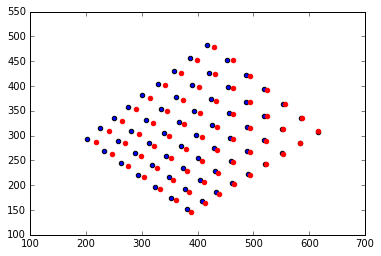

In [102]:
import matplotlib
%matplotlib inline

u,v = transformWorld2PixImageUndist(X,Y,Z,R,t,A)
    
plt.scatter(u,v)
plt.hold=True
plt.scatter(u_meas[0],v_meas[0],color="red")
#plt.xlim([0,700])
#plt.ylim([0,600])
plt.show()

## Problem 1.6

In [101]:
def transformWorld2PixImageUndist(X, Y, Z, R, t, A):
    R_t = np.hstack((R,np.array([t]).T))
    #XYZ_W = np.vstack((X,Y,Z,[1 for _ in X])).T # homogeneous world frame coordinates
    XYZ_W = np.vstack((X_big[p],Y_big[p],np.zeros(X_big[p].size),np.ones(X_big[p].shape))).T
    
    xyz_c = A.dot(R_t.dot(XYZ_W.T))
    u = xyz_c[0]/xyz_c[2]
    v = xyz_c[1]/xyz_c[2]

    return u, v

In [146]:
np.ones([2,4]).dot(np.ones([4,1]))

array([[ 4.],
       [ 4.]])

In [143]:
X_big = np.repeat(np.array([X]),12,axis=0)
Y_big = np.repeat(np.array([Y]),12,axis=0)

In [129]:
p = 1
transformWorld2PixImageUndist(X_big[p], Y_big[p], np.zeros(X_big[p].size), R_dict[p], t_dict[p], A)

(array([ 675.25779389]), array([ 143.82479926]))

In [148]:
XYZ_W = np.vstack((X_big[p],Y_big[p],np.zeros(X_big[p].size),np.ones(X_big[p].shape))).T

In [151]:
XYZ_W.T[0]

array([ 0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,
        0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,
        0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,
        0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,
        0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,
        0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,
        0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,
        0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,
        0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ])

In [142]:
X_big[0]

array([ 0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,
        0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,
        0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,
        0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,
        0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,
        0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,  0.082 ,  0.1025,
        0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,  0.041 ,  0.0615,
        0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ,  0.    ,  0.0205,
        0.041 ,  0.0615,  0.082 ,  0.1025,  0.123 ,  0.1435,  0.164 ])